In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import pywt
from scipy.signal import wiener
import skimage as skimg 

from sklearn.preprocessing import (MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer)
from sklearn.model_selection import (train_test_split, StratifiedKFold)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import (SVC)

from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.pipeline import (Pipeline, make_pipeline, FeatureUnion, make_union)
from sklearn.metrics import (classification_report, accuracy_score)

import os
import collections
from tqdm import tqdm

### Constant

In [2]:
PATH_PREFIX = 'D:/About me/intern/2022-05-09-FPT High order wavelet/data/Subset DS05/'
PATH_PREFIX_CABLE = 'D:/About me/intern/2022-05-09-FPT High order wavelet/data/recap_data/'
os.path.exists(PATH_PREFIX)

True

In [3]:
class CLASS():
    FAKE = 0
    REAL = 1

WT_NAME = 'db5'
LEVEL = 3
IMG_SIZE = (1024, 1024)
LBP_IMG_SIZE = (1024, 1024)
RAVEL = 0
# TOTAL_PIXELS = 64*64

### Load image

In [4]:
def load_img():
    folders = [os.path.join(PATH_PREFIX + f)
               for f in os.listdir(PATH_PREFIX) if f[0] == 'C']
    images = []
    labels = []

    for i, folder in enumerate(folders):
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # img = cv2.resize(img, dsize=IMG_SIZE)
                images.append(img)
                labels.append(CLASS.REAL if i < 3 else CLASS.FAKE)
    
    return (images, labels)

In [5]:
def load_img_cable():
    folders = [os.path.join(PATH_PREFIX_CABLE + f)
               for f in os.listdir(PATH_PREFIX_CABLE)]
    images = []
    labels = []

    for i, folder in enumerate(folders):
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # img = cv2.resize(img, dsize=IMG_SIZE)
                images.append(img)
                labels.append(CLASS.REAL if i < 1 else CLASS.FAKE)
    
    return (images, labels)

### Feature Transformer

In [6]:
class WaveletFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, wtname = 'db5', level = 3):
        '''
        waveletname = ['db3', 'db4', 'db5', 'sym2', 'bior5.5', etc.]
        level: total number of decomposite level
        '''
        self.wtname = wtname
        self.level = level

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return self.get_wavelet_features(X)

    def get_wavelet_features(self, images):
        def wavelet_decrete_transform(img):
            wt = pywt.wavedec2(data=img, wavelet=self.wtname, level=self.level)
            apprx = wt[0]
            details = wt[1:]
            return apprx, details

        def get_wavelet_characteristics(apprx, details):
            def get_mean(img_wt: np.ndarray):
                return np.mean(img_wt)

            def get_variance(img_wt: np.ndarray):
                img_wt = img_wt - mean
                img_wt = img_wt**2
                return np.mean(img_wt)

            def get_skew(img_wt: np.ndarray):
                img_wt = img_wt - mean
                img_wt = img_wt**3
                return np.mean(img_wt)

            def get_single_chrc(img_wt):
                mean = get_mean(img_wt)
                return (mean, get_variance(img_wt), get_skew(img_wt))

            mean = 0
            chrc = []
            for a in get_single_chrc(apprx):
                chrc.append(a)
            for level_detail in details:
                for h in level_detail:
                    for a in get_single_chrc(h):
                        chrc.append(a)
            return np.array(chrc)

        wt_features = []
        for img in tqdm(images):
            img_low_pass, img_high_pass = wavelet_decrete_transform(img)
            wt_features.append(get_wavelet_characteristics(img_low_pass, img_high_pass))
        
        # wt_features = MinMaxScaler().fit_transform(wt_features)
        return np.array(wt_features)

In [7]:
class MoreWavetletFeatureTfm(BaseEstimator, TransformerMixin):
    def __init__(self, wtname = 'db5', level = 3):
        '''
        waveletname = ['db3', 'db4', 'db5', 'sym2', 'bior5.5', etc.]
        level: total number of decomposite level
        '''
        self.wtname = wtname
        self.level = level

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        wt_features = []
        for img in tqdm(X):
            img_low_pass, img_high_pass = self.wavelet_decrete_transform(img)
            wt_features.append(self.get_feature(img_low_pass, img_high_pass))
        return np.array(wt_features)
    
    def wavelet_decrete_transform(self, img):
        wt = pywt.wavedec2(data=img, wavelet=self.wtname, level=self.level)
        apprx = wt[0]
        details = wt[1:]
        return apprx, details

    def get_feature(self, apprx, details):
        f = []
        for a in self.get_single_img_features(apprx):
            f.append(a)
        for level_detail in details:
            for h in level_detail:
                for a in self.get_single_img_features(h):
                    f.append(a)
        return f

    def get_single_img_features(self, img):
        # img = img.flatten()
        # entropy = self.calculate_entropy(img)
        # crossings = self.calculate_crossings(img)
        statistics = self.calculate_statistics(img)
        # return np.concatenate((entropy, crossings, statistics))
        return statistics

    def calculate_statistics(self, img):
        n5 = np.percentile(img, 5)
        n25 = np.percentile(img, 25)
        n75 = np.percentile(img, 75)
        n95 = np.percentile(img, 95)
        median = np.percentile(img, 50)
        mean = np.mean(img)
        std = np.std(img)
        var = np.var(img)
        skew = np.mean((img - mean)**3)
        rms = np.mean(np.sqrt(img**2))
        return (n5, n25, n75, n95, median, mean, std, var, skew, rms)

    # def calculate_entropy(self, list_values):
    #     counter_values = collections.Counter(list_values).most_common()
    #     probabilities = [elem[1]/len(list_values) for elem in counter_values]
    #     entropy=scipy.stats.entropy(probabilities)
    #     return entropy

    # def calculate_crossings(self, img):
    #     zero_crossing_indices = np.nonzero(np.diff(np.array(img), 0))[0]
    #     no_zero_crossings = len(zero_crossing_indices)
    #     mean_crossing_indices = np.nonzero(np.diff(np.array(img), np.nanmean(img)))[0]
    #     no_mean_crossings = len(mean_crossing_indices)
    #     return [no_zero_crossings, no_mean_crossings]

In [8]:
class NoiseFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_points = 8, radius = 1, wiener_size = 5):
        self.num_points = num_points
        self.radius = radius
        self.wiener_size = wiener_size
        # self.ravel = 0

    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return self.get_lbp_features(X)

    def get_lbp_features(self, images):
        def local_binary_pattern(img):
            noise = img - wiener(img, self.wiener_size)
            lbp = skimg.feature.local_binary_pattern(
                noise, self.num_points, self.radius, method="nri_uniform").ravel()
            (hist, bins) = np.histogram(lbp.ravel(), bins=59)
            # hist = hist / len(lbp)
            return hist

        lbp_features = []
        for img in tqdm(images):
            # img = cv2.resize(img, LBP_IMG_SIZE)
            lbp_features.append(local_binary_pattern(img))
        return lbp_features

In [9]:
def percentage_normalize(X):
    X_normalized = []
    for x in X:
        x = x / np.sum(x)
        X_normalized.append(x)
    return np.array(X_normalized)

per_normalizer = FunctionTransformer(percentage_normalize)

### Pipelines

In [10]:
wt_transforms = (
    make_pipeline(WaveletFeatureTransformer(), MinMaxScaler()),
    make_pipeline(WaveletFeatureTransformer(), StandardScaler()),
    make_pipeline(WaveletFeatureTransformer(), Normalizer()),
)

noise_transforms = (
    make_pipeline(NoiseFeatureTransformer(), per_normalizer),
    make_pipeline(NoiseFeatureTransformer(), MinMaxScaler()),
    make_pipeline(NoiseFeatureTransformer(), Normalizer()),
)

In [11]:
feature_transforms = (
    make_union(wt_transforms[0], noise_transforms[0]),
    make_union(wt_transforms[0], noise_transforms[2]),
    make_union(wt_transforms[2], noise_transforms[0]),
    make_union(WaveletFeatureTransformer(), noise_transforms[0]),
)

In [12]:
pipes = (
    make_pipeline(feature_transforms[0], StandardScaler(), SVC()),
    make_pipeline(feature_transforms[0], MinMaxScaler(), SVC()),
    make_pipeline(feature_transforms[0], StandardScaler(), GradientBoostingClassifier()),
    make_pipeline(feature_transforms[3], MinMaxScaler(), GradientBoostingClassifier()),
    make_pipeline(feature_transforms[1], StandardScaler(), SVC()),
    make_pipeline(feature_transforms[3], StandardScaler(), SVC()),
)

In [13]:
pipes[0]

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('waveletfeaturetransformer',
                                                                  WaveletFeatureTransformer()),
                                                                 ('minmaxscaler',
                                                                  MinMaxScaler())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('noisefeaturetransformer',
                                                                  NoiseFeatureTransformer()),
                                                                 ('functiontransformer',
                                                                  FunctionTransformer(func=<function percentage_normalize at 0x000001BBA03CF400>))]))])),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

# Train

In [10]:
import warnings
warnings.filterwarnings("ignore")

### Read images

In [11]:
# Cable dataset
X, y = load_img_cable()

In [12]:
X = np.array(X)
y = np.array(y)

In [13]:
print(len(X), len(y))

492 492


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
axs[0].imshow(X[0], cmap='gray')
axs[1].imshow(X[1], cmap='gray')
plt.show()

In [14]:
# DS05 dataset
U, v = load_img()

In [15]:
U = np.array(U)
v = np.array(v)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
axs[0].imshow(U[0], cmap='gray')
axs[1].imshow(U[1], cmap='gray')
plt.show()

## Train on A - test on B

### *KFold & StratifiedKFold*

Init Test Pipes

In [91]:
pipes = [
    make_pipeline(feature_transforms[0], StandardScaler(), SVC()),
    make_pipeline(feature_transforms[2], StandardScaler(), SVC()),
    make_pipeline(feature_transforms[3], StandardScaler(), SVC()),
    make_pipeline(feature_transforms[0], StandardScaler(), GradientBoostingClassifier()),
]

In [92]:
pipes[0]

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('waveletfeaturetransformer',
                                                                  WaveletFeatureTransformer()),
                                                                 ('minmaxscaler',
                                                                  MinMaxScaler())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('noisefeaturetransformer',
                                                                  NoiseFeatureTransformer()),
                                                                 ('functiontransformer',
                                                                  FunctionTransformer(func=<function percentage_normalize at 0x000002BB0310E440>))]))])),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

Train on Cable - Test on DS05

Valid 0.97 - Test 0.52 (outdated)

In [ ]:
kf = StratifiedKFold(shuffle=True, random_state=42)
# c_models = []
score_valid = 0
score_test = 0
pipe_num = 0
for k, (i_train, i_test) in enumerate(kf.split(X, y)):
    model = pipes[pipe_num].fit(X[i_train], y[i_train])
    # c_models.append(model)

    y_pred = model.predict(X[i_test])
    acc_valid = accuracy_score(y_true=y[i_test], y_pred=y_pred)
    score_valid += acc_valid
    # print(classification_report(y_pred=y_pred, y_true=y[i_test]))

    v_pred = model.predict(U)
    acc_test = accuracy_score(y_true=v, y_pred=v_pred)
    score_test += acc_test
    # print(classification_report(y_pred=v_pred, y_true=v))

    print("[Fold {}]".format(k+1))
    print("Valid: {:.3f}".format(acc_valid))
    print("Test:  {:.3f}".format(acc_test))

print("Mean valid acc: {:.3f}".format(score_valid/5))
print("Mean test acc:  {:.3f}".format(score_test/5))

Train on DS05 - Test on Cable

Valid 0.6 - Test 0.5 (outdated)

In [103]:
kf = StratifiedKFold(shuffle=True, random_state=42)
# d_models = []
score_valid = 0
score_test = 0
pipe_num = 0
for k, (i_train, i_test) in tqdm(enumerate(kf.split(U, v))):
    model = pipes[pipe_num].fit(U[i_train], v[i_train])
    # d_models.append(model)

    v_pred = model.predict(U[i_test])
    acc_valid = accuracy_score(y_true=v[i_test], y_pred=v_pred)
    score_valid += acc_valid
    # print(classification_report(y_pred=v_pred, y_true=v[i_test]))

    # y_pred = model.predict(X)
    # acc_test = accuracy_score(y_true=y, y_pred=y_pred)
    # score_test += acc_test
    # print(classification_report(y_pred=y_pred, y_true=y))

    print("[Fold {}]".format(k+1))
    print("Valid: {:.3f}".format(acc_valid))
    # print("Test:  {:.3f}\n".format(acc_test))

print("Mean valid acc: {:.3f}".format(score_valid/5))
print("Mean test acc:  {:.3f}".format(score_test/5))

100%|██████████| 30/30 [01:29<00:00,  2.99s/it]
1it [05:22, 322.30s/it]

[Fold 1]
Valid: 0.900


100%|██████████| 30/30 [00:42<00:00,  1.42s/it]
2it [11:15, 340.58s/it]

[Fold 2]
Valid: 0.800


100%|██████████| 30/30 [01:46<00:00,  3.55s/it]
3it [18:58, 396.51s/it]

[Fold 3]
Valid: 0.900


100%|██████████| 30/30 [00:45<00:00,  1.50s/it]
4it [25:39, 398.09s/it]

[Fold 4]
Valid: 0.767


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]
5it [29:53, 358.67s/it]

[Fold 5]
Valid: 1.000
Mean valid acc: 0.873
Mean test acc:  0.000


### Wonder why train on A and wrongly predict on B

Visualization with UMap

In [15]:
import umap
import seaborn as sns
from sklearn.decomposition import PCA

In [61]:
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.1,
    random_state=42)

In [17]:
sns_cmap = sns.color_palette()
color_mapper = {
    CLASS.FAKE : sns_cmap[0],
    CLASS.REAL : sns_cmap[1],
    # CLASS.FAKE_C : sns_cmap[2],
    # CLASS.REAL_C : sns_cmap[3],
}
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [73]:
# transformer = make_pipeline(WaveletFeatureTransformer(level=1), StandardScaler())
transformer = make_pipeline(feature_transforms[0], StandardScaler())
transformer

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('waveletfeaturetransformer',
                                                                  WaveletFeatureTransformer()),
                                                                 ('minmaxscaler',
                                                                  MinMaxScaler())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('noisefeaturetransformer',
                                                                  NoiseFeatureTransformer()),
                                                                 ('functiontransformer',
                                                                  FunctionTransformer(func=<function percentage_normalize at 0x000002BB0183B490>))]))])),
                ('standardscaler', StandardScaler())])

In [74]:
U_f = transformer.fit_transform(U, v)

In [75]:
embedding = reducer.fit_transform(U_f)
embedding.shape

(150, 2)

Text(0.5, 1.0, 'DS05 - No resize - 30')

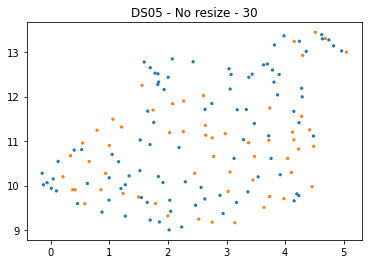

In [76]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for a in v],
    s=5)
plt.title('DS05 - {} - {}'.format('No resize', reducer.n_neighbors))

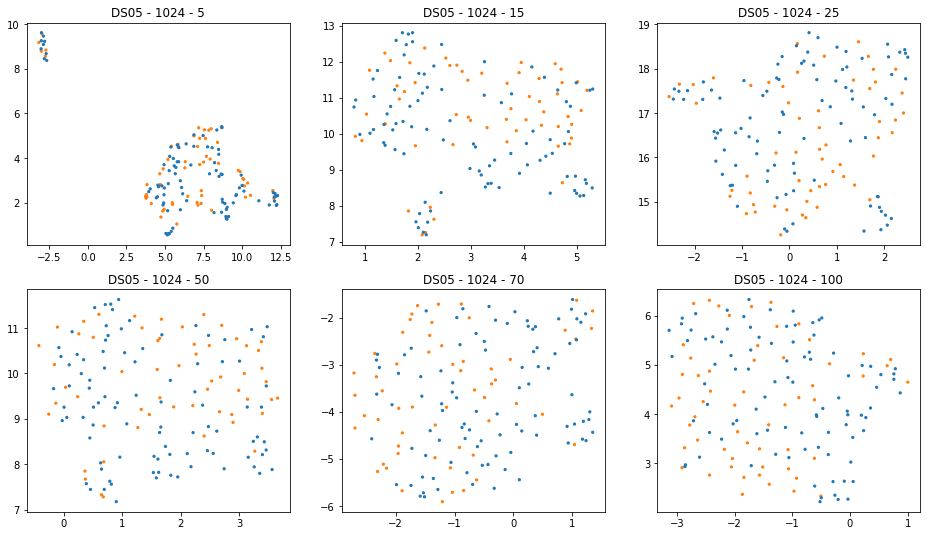

In [77]:
N = (5, 15, 25, 50, 70, 100)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
for a,n in enumerate(N):
    reducer = umap.UMAP(n_neighbors=n,
                        min_dist=0.1,
                        random_state=42)
    embedding = reducer.fit_transform(U_f)
    embedding.shape
    i = a // 3
    j = a % 3
    axs[i,j].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[color_mapper[a] for a in v],
        s=5)
    axs[i,j].set_title('DS05 - {} - {}'.format(LBP_IMG_SIZE[0], reducer.n_neighbors))
    # axs[i,j].set_xticks([])
    # axs[i,j].set_yticks([])
plt.show()

Text(0.5, 1.0, 'PCA(None) - UMap(30)')

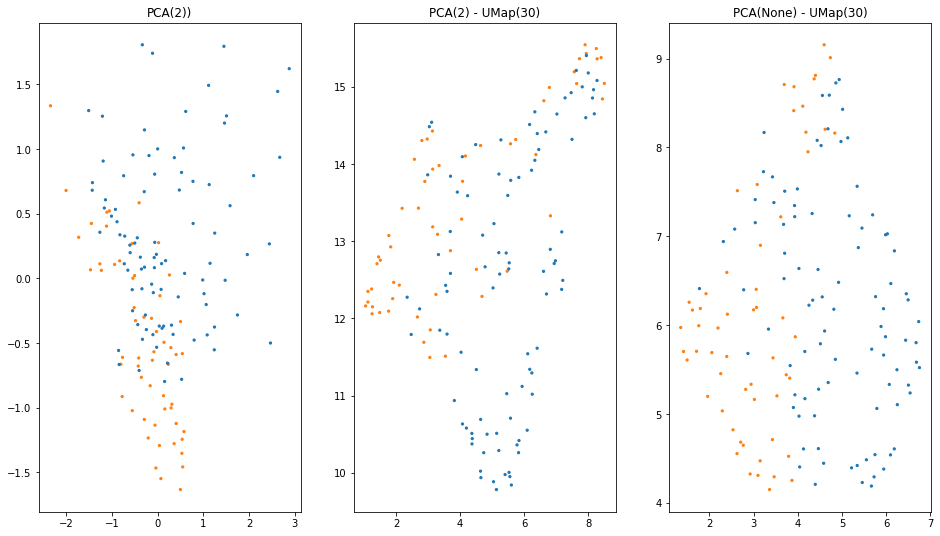

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,9))
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    random_state=42)

pca = PCA(n_components=2)
U_pca = pca.fit_transform(U_f)
axs[0].scatter(
    U_pca[:, 0],
    U_pca[:, 1],
    c=[color_mapper[a] for a in v],
    s=5)
axs[0].set_title('PCA({}))'.format(pca.n_components))

embedding = reducer.fit_transform(U_pca)
axs[1].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for a in v],
    s=5)
axs[1].set_title('PCA({}) - UMap({})'.format(pca.n_components, reducer.n_neighbors))

pca = PCA()
U_pca = pca.fit_transform(U_f)
embedding = reducer.fit_transform(U_pca)
axs[2].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for a in v],
    s=5)
axs[2].set_title('PCA({}) - UMap({})'.format(pca.n_components, reducer.n_neighbors))

In [151]:
X_f = transformer.fit_transform(X, y)

In [152]:
embedding = reducer.fit_transform(X_f)
embedding.shape

(492, 2)

Text(0.5, 1.0, 'UMAP projection - Cable')

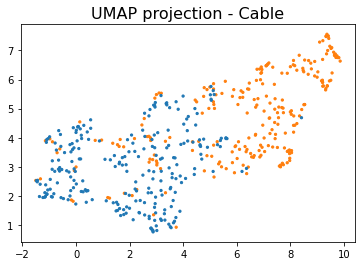

In [153]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for a in y],
    s=5)
plt.title('UMAP projection - Cable', fontsize=16)

## Train on both dataset

### Prepare data

In [16]:
y_ds = [0] * len(y)
y_2d = np.stack((y, y_ds)).T
v_ds = [1] * len(v)
v_2d = np.stack((v, v_ds)).T
print(y_2d.shape, v_2d.shape)

(492, 2) (150, 2)


In [17]:
X_train, X_test, y_train2d, y_test2d = train_test_split(X, y_2d, train_size=0.7, random_state=42, stratify=y)
U_train, U_test, v_train2d, v_test2d = train_test_split(U, v_2d, train_size=0.7, random_state=42, stratify=v)

In [18]:
A_train = np.concatenate((X_train, U_train))
A_test = np.concatenate((X_test, U_test))
b_train = np.concatenate((y_train2d[:, 0], v_train2d[:, 0]))
b_test = np.concatenate((y_test2d[:, 0], v_test2d[:, 0]))

In [19]:
b_train_ds = np.concatenate((y_train2d[:, 1], v_train2d[:, 1]))
b_test_ds = np.concatenate((y_test2d[:, 1], v_test2d[:, 1]))

### Fit with pre-compute feature

#### Extract feature

In [49]:
f_extractor = feature_transforms[0]
f_extractor

FeatureUnion(transformer_list=[('pipeline-1',
                                Pipeline(steps=[('waveletfeaturetransformer',
                                                 WaveletFeatureTransformer()),
                                                ('minmaxscaler',
                                                 MinMaxScaler())])),
                               ('pipeline-2',
                                Pipeline(steps=[('noisefeaturetransformer',
                                                 NoiseFeatureTransformer()),
                                                ('functiontransformer',
                                                 FunctionTransformer(func=<function percentage_normalize at 0x000002041E9EA830>))]))])

In [50]:
Af_train = f_extractor.fit_transform(A_train, b_train)

100%|██████████| 449/449 [20:19<00:00,  2.72s/it] 


In [51]:
Af_test = f_extractor.fit_transform(A_test, b_test)

100%|██████████| 193/193 [08:33<00:00,  2.66s/it]


Concat

In [227]:
Af = np.concatenate((Af_train, Af_test))
b = np.concatenate((b_train, b_test))
b_ds = np.concatenate((b_train_ds, b_test_ds))

#### Dump feature object

In [10]:
PATH_DUMP = 'D:/About me/intern/2022-05-09-FPT High order wavelet/code/recaptured image - wavelet (sun2017)/object dump'
os.path.exists(PATH_DUMP)

True

In [64]:
np.save(os.path.join(PATH_DUMP, 'Af_train.npy'), Af_train)
np.save(os.path.join(PATH_DUMP, 'Af_test.npy'), Af_test)

In [222]:
np.save(os.path.join(PATH_DUMP, 'Af.npy'), Af)
np.save(os.path.join(PATH_DUMP, 'b.npy'), b)
np.save(os.path.join(PATH_DUMP, 'b_ds.npy'), b_ds)

#### Load feature

In [1]:
PATH_DUMP = 'D:/About me/intern/2022-05-09-FPT High order wavelet/code/recaptured image - wavelet (sun2017)/object dump'
os.path.exists(PATH_DUMP)

True

In [12]:
Af = np.load(os.path.join(PATH_DUMP, 'Af.npy'))
b = np.load(os.path.join(PATH_DUMP, 'b.npy'))
b_ds = np.load(os.path.join(PATH_DUMP, 'b_ds.npy'))

#### Fit

In [13]:
estimators = [
    make_pipeline(StandardScaler(), SVC()),  # 95
    make_pipeline(MinMaxScaler(), SVC()),  # 96
    make_pipeline(StandardScaler(), GradientBoostingClassifier()),  # 84, predict cable wrong (~24)
    make_pipeline(MinMaxScaler(), GradientBoostingClassifier()),  # 86, predict cable wrong
]

In [38]:
_Af_train, _Af_test, _b_train2d, _b_test2d = train_test_split(Af,
                                                          np.stack((b,b_ds), axis=-1),
                                                          train_size=0.7,
                                                          random_state=12,
                                                          stratify=b)
_b_train = _b_train2d[:, 0]
_b_test = _b_test2d[:, 0]
_b_test_ds = _b_test2d[:, 1]

In [39]:
_Af_train.shape

(449, 89)

In [40]:
estimator = estimators[0].fit(_Af_train, _b_train)
estimator

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [44]:
b_pred = estimator.predict(_Af_test)
print(classification_report(_b_test, b_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       102
           1       0.99      0.91      0.95        91

    accuracy                           0.95       193
   macro avg       0.96      0.95      0.95       193
weighted avg       0.96      0.95      0.95       193



In [45]:
acc_list = (b_pred!=_b_test) * (_b_test_ds+1)
print('Count incorrect pred with dataset (Cable, DS05):')
print(np.count_nonzero(acc_list==1),
      np.count_nonzero(acc_list==2))
print('Percentage of incorrect pred of DS05:')
print(np.count_nonzero(acc_list==2),
      np.count_nonzero(_b_test_ds==2-1),
      sep='/')

Count incorrect pred with dataset (Cable, DS05):
0 9
Percentage of incorrect pred of DS05:
9/45


In [46]:
acc_list = (b_pred!=_b_test)
print('Count incorrect pred with ground truth class (fake, real):')
print(np.count_nonzero((acc_list) & (_b_test==0)),
      np.count_nonzero((acc_list) & (_b_test==1)))

Count incorrect pred with ground truth class (fake, real):
1 8


#### Visualize

In [86]:
import umap
import seaborn as sns

In [96]:
sns_cmap = sns.color_palette()
color_mapper = {
    0 : sns_cmap[0],  # fake
    1 : sns_cmap[1],  # real
    2 : sns_cmap[2],  # fake_DS05
    3 : sns_cmap[3],  # real_DS05
}
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [212]:
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    random_state=42)
scaler = StandardScaler()

In [187]:
# Af = np.concatenate((Af_train, Af_test))
# b = np.concatenate((b_train, b_test))
# b_ds = np.concatenate((b_train_ds, b_test_ds))

In [217]:
Af_s = scaler.fit_transform(Af)

In [213]:
embedding = reducer.fit_transform(Af_s)
embedding.shape

(642, 2)

Text(0.5, 1.0, 'Both - No resize - 50')

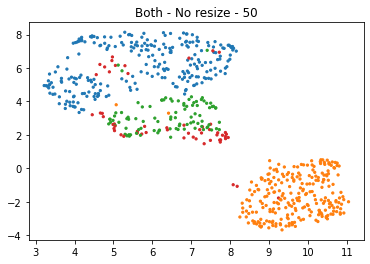

In [215]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a + 2*b_ds[i]] for i, a in enumerate(b)],
    s=5)
ax.set_title('Both - {} - {}'.format('No resize', reducer.n_neighbors))

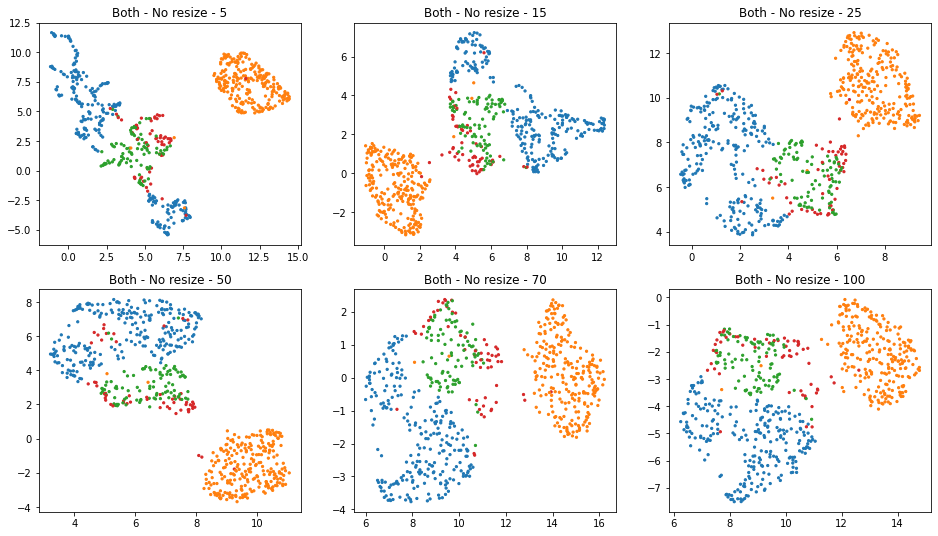

In [219]:
N = (5, 15, 25, 50, 70, 100)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9))
for a,n in enumerate(N):
    reducer = umap.UMAP(n_neighbors=n,
                        min_dist=0.25,
                        random_state=42)
    embedding = reducer.fit_transform(Af_s)
    i = a // 3
    j = a % 3
    axs[i,j].scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[color_mapper[a + 2*b_ds[i]] for i, a in enumerate(b)],
        s=5)
    axs[i,j].set_title('Both - {} - {}'.format('No resize', reducer.n_neighbors))
    # axs[i,j].set_xticks([])
    # axs[i,j].set_yticks([])
plt.show()

#### Verify by plotting DS05

In [122]:
Uf = []
vf = []
for i,a in enumerate(Af_s):
    if b_ds[i] == 1:
        Uf.append(a)
        vf.append(b[i])

In [124]:
Uf = np.array(Uf)
vf = np.array(vf)

In [125]:
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.1,
    random_state=42)
embedding = reducer.fit_transform(Uf)
embedding.shape

(150, 2)

Text(0.5, 1.0, 'DS05 - No resize - 50')

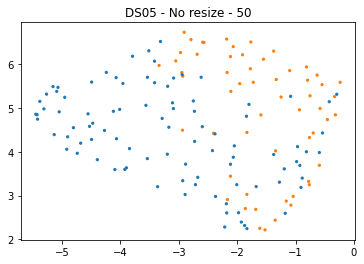

In [126]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a] for a in vf],
    s=5)
plt.title('DS05 - {} - {}'.format('No resize', reducer.n_neighbors))

#### KFold

In [245]:
# Af = np.concatenate((Af_train, Af_test))
# b = np.concatenate((b_train, b_test))
# b_ds = np.concatenate((b_train_ds, b_test_ds))

In [238]:
estimators = [
    make_pipeline(StandardScaler(), SVC()),  # 95.5
    make_pipeline(MinMaxScaler(), SVC()),  # 95.6
    make_pipeline(StandardScaler(), GradientBoostingClassifier()),  # 95.0
    make_pipeline(MinMaxScaler(), GradientBoostingClassifier()),  # 95.5
]

In [239]:
def kfold(_estimator):
    print(_estimator)
    
    kf = StratifiedKFold(shuffle=True, random_state=17)
    score = 0
    for k, (i_train, i_test) in enumerate(kf.split(Af, b)):
        model = _estimator.fit(Af[i_train], b[i_train])

        y_pred = model.predict(Af[i_test])
        acc = accuracy_score(y_true=b[i_test], y_pred=y_pred)
        score += acc

        print("[Fold {}] Acc: {:.3f}".format(k+1, acc))
        # print(classification_report(y_true=b[i_test], y_pred=y_pred))
        # print("Acc: {:.3f}".format(acc))

    print("Mean acc: {:.3f}\n".format(score/5))

In [243]:
for e in estimators:
    kfold(e)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])
[Fold 1] Acc: 0.977
[Fold 2] Acc: 0.938
[Fold 3] Acc: 0.945
[Fold 4] Acc: 0.961
[Fold 5] Acc: 0.961
Mean acc: 0.956

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC())])
[Fold 1] Acc: 0.969
[Fold 2] Acc: 0.953
[Fold 3] Acc: 0.922
[Fold 4] Acc: 0.961
[Fold 5] Acc: 0.969
Mean acc: 0.955

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])
[Fold 1] Acc: 0.953
[Fold 2] Acc: 0.961
[Fold 3] Acc: 0.922
[Fold 4] Acc: 0.945
[Fold 5] Acc: 0.969
Mean acc: 0.950

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])
[Fold 1] Acc: 0.953
[Fold 2] Acc: 0.961
[Fold 3] Acc: 0.922
[Fold 4] Acc: 0.945
[Fold 5] Acc: 0.969
Mean acc: 0.950



### Fit with only MoreWaveletFeature()

In [60]:
pipe = make_pipeline(MoreWavetletFeatureTfm(), MinMaxScaler(), SVC())

In [61]:
model = pipe.fit(A_train, b_train)

100%|██████████| 449/449 [06:42<00:00,  1.11it/s]


In [62]:
b_pred = model.predict(A_test)
print(classification_report(b_test, b_pred))

100%|██████████| 193/193 [02:44<00:00,  1.17it/s]

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       102
           1       0.99      0.87      0.92        91

    accuracy                           0.93       193
   macro avg       0.94      0.93      0.93       193
weighted avg       0.94      0.93      0.93       193



In [76]:
acc_list = (b_pred!=b_test) * (b_test_ds+1)
print('Count incorrect pred with dataset (Cable, DS05):')
print(np.count_nonzero(acc_list==1),
      np.count_nonzero(acc_list==2))
print('Percentage of incorrect pred of DS05:')
print(np.count_nonzero(acc_list==2),
      np.count_nonzero(b_test_ds==2-1),
      sep='/')

Count incorrect pred with dataset (Cable, DS05):
0 13
Percentage of incorrect pred of DS05:
13/45


In [77]:
acc_list = (b_pred!=b_test)
print('Count incorrect pred with ground truth class (fake, real):')
print(np.count_nonzero((acc_list) & (b_test==0)),
      np.count_nonzero((acc_list) & (b_test==1)))

Count incorrect pred with ground truth class (fake, real):
1 12


In [63]:
import umap
import seaborn as sns

In [71]:
sns_cmap = sns.color_palette()
color_mapper = {
    0 : sns_cmap[0],  # fake
    1 : sns_cmap[1],  # real
    2 : sns_cmap[2],  # fake_DS05
    3 : sns_cmap[3],  # real_DS05
}
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [65]:
A = np.concatenate((A_train, A_test))
b = np.concatenate((b_train, b_test))
b_ds = np.concatenate((b_train_ds, b_test_ds))

In [66]:
f_extractor = make_pipeline(MoreWavetletFeatureTfm(), MinMaxScaler())
f_extractor

Pipeline(steps=[('morewavetletfeaturetfm', MoreWavetletFeatureTfm()),
                ('minmaxscaler', MinMaxScaler())])

In [67]:
Af = f_extractor.fit_transform(A, b)

100%|██████████| 642/642 [24:48<00:00,  2.32s/it]


In [73]:
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.25,
    random_state=42)

In [74]:
embedding = reducer.fit_transform(Af)
embedding.shape

(642, 2)

Text(0.5, 1.0, 'More wavelet - No resize - 100')

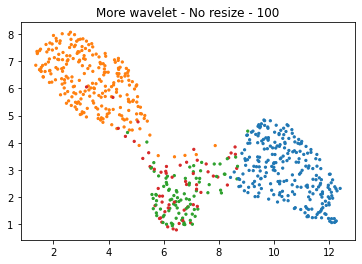

In [75]:
fig, ax = plt.subplots()
scatter = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_mapper[a + 2*b_ds[i]] for i, a in enumerate(b)],
    s=5)
ax.set_title('More wavelet - {} - {}'.format('No resize', reducer.n_neighbors))